In [47]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

# s=1 growth rates
dtheta_rate = {
    0.2: 0.8313409423823516,
    0.4: 0.6704432477570811,
    0.8: 0.456550549109,
    1.2: 0.3444444444,
    1.6: 0.291629202186,
    2.0: 0.251843521922}

def integrate_term(reader,steps,term):
    
    mat = np.zeros([len(steps),2])
    for i,step in enumerate(steps):
        reader.step = step
        time = reader.time
        
        # integrate
        dat = reader.readData(term)        
        mat[i,0] = time
        mat[i,1] = integrate_y(y,np.squeeze(dat))
    
    # sort by time
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]
        

directory = '/home/kmatsuno/ShearLayerData/production/Mc12/rr1/1024x1448x512/'

filename_prefix = directory + '/TKEBudget_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

steps = sorted(reader.steps)
print("Steps: {}".format(steps))

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 1.2
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 100.0x100.0x50.0
Steps: [0, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 30, 34]


(1.2, 1.0)


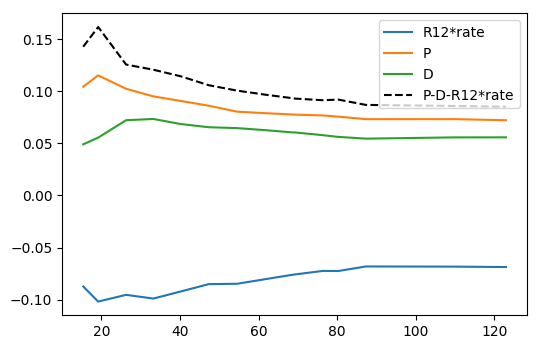

In [49]:
# Integrated profiles

fig = plt.figure(dpi=100)
int_P = integrate_term(reader,steps,'production')
int_D = integrate_term(reader,steps,'dissipation')
# int_D_num = integrate_term(reader,steps,'dissipation_num')
# int_D[:,1] += int_D_num[:,1]
int_R12 = integrate_term(reader,steps,'R_12')

t = int_P[:,0]
Nt = np.size(t)
for i in range(Nt):
    # Get dtheta
    idx = np.argmin(abs(tlist-t[i]))
    dtheta = dlist[idx]
    
    int_R12[i,1] *= dtheta_rate[inp.Mc]/dtheta

plt.plot(t,int_R12[:,1],label=r'R12*rate')
plt.plot(t,int_P[:,1],label='P')
plt.plot(t,int_D[:,1],label='D')
plt.plot(t,int_P[:,1]-int_D[:,1]-int_R12[:,1],'k--',label='P-D-R12*rate')
plt.legend()

# plt.plot(int_D[:,0]/inp.du,int_D[:,1],'-*')
print(inp.Mc,inp.rr)


0.4:[0.000283967416084,6.44372185785e-05],
(0.4, 1.0)


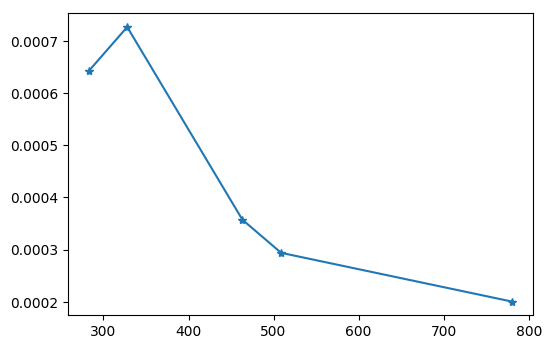

In [13]:
def get_rbar(Mc):
    if Mc == 2: return 0.7
    elif Mc==1.6: return 0.8
    elif Mc==1.2: return 0.85
    elif Mc==0.8: return 0.95
    elif Mc==0.4: return 0.98
    elif Mc==0.2: return 0.995
    
def scale_term(directory,reader,steps,term):
    tIDlist = get_tIDlist(directory)
    mat = np.zeros([len(steps),2])
    for i,step in enumerate(steps):
        reader.step = step
        time = reader.time
        
        idx = np.argmin(abs(time-tIDlist[:,0]))
        tID = tIDlist[idx,1]
        
        # Get dtheta
        dtheta = get_dtheta(directory,time)

        # Get lscale y
        autocorr = np.fromfile(directory+'shearlayer_lscale_vv_%04d'%(tID)+'.dat',dtype=float,sep=' ')
        ly = get_lscale(y,autocorr)
        
        # Get 99% lengthscale
        utilde = np.fromfile( directory+'shearlayer_utilde_%04d.dat'%tID, sep=' ')
        L99,i1,i2 = get_L99(y,utilde)
        
        # integrate
        dat = reader.readData(term)
        dudy = inp.du / L99
        scale = (dtheta/ly)**2 / inp.du**2 / dudy / get_rbar(inp.Mc)
        mat[i,0] = time
        mat[i,1] = integrate_y(y,np.squeeze(dat)) * scale / L99
    
    # sort by time
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]
        

fig = plt.figure(dpi=100)
mat = scale_term(directory,reader,steps[1:],'production')
f = mat[:,1]
plt.plot(mat[:,0]/inp.du,mat[:,1],'-*')
idx = 2
print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:]),np.std(f[idx:])))
print(inp.Mc,inp.rr)

In [4]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']

fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/TKEBudget_'
    reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    steps = reader.steps

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')
    
    int_P = integrate_term(reader,steps,'production')
    int_D = integrate_term(reader,steps,'dissipation')
    int_R12 = integrate_term(reader,steps,'R_12')
    
    t = int_P[:,0]
    resid = int_P
    for i in range(np.size(t)):
        # Get dtheta
        idx = np.argmin(abs(tlist-t))
        dtheta = dlist[idx]
        
        # Get residual
        resid[i,1] = 
        
        
    
    plt.plot(t,resid,'-*',label='Mc={}'.format(inp.Mc))
    
    ist = 2
    ien = None
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[ist:ien]),np.std(f[ist:ien])))
    
print('Done')
plt.grid(True)
plt.legend()
plt.xlim([0,200])
# ax[0].set_ylim([-5e-4,1e-3])
# plt.savefig('/home/kmatsuno/ShearLayer_img/vs_t/'+'diss_s%s'%s,dpi=200,bbox_inches='tight')

NameError: name 'integrate_term' is not defined

<Figure size 750x450 with 0 Axes>

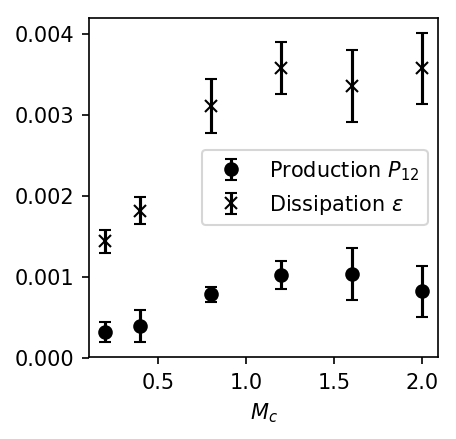

In [6]:
prod = {
0.2:[0.000318870316419,0.000125234495132],
0.4:[0.000394662517956,0.000199685585582],
0.8:[0.000782856945129,9.62955897386e-05],
1.2:[0.00101800804794,0.000172559433891],
1.6:[0.00103279264502,0.000320385771619],
2.0:[0.000818715663743,0.000318817992458],
}
diss = {
0.2:[0.00143701261034,0.000139456200893],
0.4:[0.00181731204954,0.000165935224246],
0.8:[0.00310778034047,0.000328730645707],
1.2:[0.00357820075901,0.000318249074369],
1.6:[0.00335861795633,0.000442970721879],
2.0:[0.00357090409314,0.000435806161689],
}
def plotter(dat,label,fmt):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],fmt=fmt,label=label,capsize=3)
fig = plt.figure(figsize=(3,3),dpi=150)
plotter(prod,r'Production $P_{12}$','ko')
plotter(diss,r'Dissipation $\epsilon$','kx')
plt.xlabel(r'$M_c$')
plt.legend()
# plt.grid(True)